# Notebook 12: Describing Function
© 2024 ETH Zurich, Mark Benazet Castells, Jonas Holinger, Felix Muller, Matteo Penlington; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

This notebook explores non-linear gains, how to determine the absolute stability of the system, and how to use describing functions to identify the presence of potential limit cycles, and whether they are stable.

Authors:
- Mark Benazet Castells; mbenazet@ethz.ch
- Shubham Gupta; shugupta@ethz.ch
- Jonas Holinger; jholinger@ethz.ch
- Felix Muller; fmuller@ethz.ch


# Learning Objectives

After completing this material, you should be able to:

1. **Understand the role of nonlinearities in control systems:**
   - Identify common static (memoryless) nonlinearities such as saturation, dead-zone, quantization, and Schmitt trigger. 
   - Distinguish between static nonlinearities and nonlinearities with memory, such as hysteresis.
   - Explain why linear analysis tools are insufficient for nonlinear systems and how the describing function method addresses this limitation.

2. **Apply absolute stability criteria for nonlinear feedback systems:**
   - Understand the concept of absolute stability for a system with one static nonlinearity.
   - Use necessary and sufficient conditions to determine absolute stability.
  
3. **Apply the describing function method:**
   - Derive the describing function $N(A)$ provided a system description.
   - Approximate a nonlinear system using its describing function as an amplitude-dependent gain.

4. **Analyze limit cycles in nonlinear feedback systems:**
   - Recognize how limit cycles can arise in nonlinear feedback systems.
   - Identify limit cycles by locating intersections of the polar plot of $L(j\omega)$ with $-1/N(A)$.
   - Predict the amplitude and frequency of limit cycles using the describing function method.

5. **Assess the stability of limit cycles:**
   - Determine the stability of limit cycles using an extension of the Nyquist stability criterion.
   - Identify whether perturbations in amplitude grow or decay, and explain how this helps in determining the stability of a limit cycle.


## Required Packages



Run the following cell to import required packages:

In [ ]:
%pip install numpy matplotlib scipy ipywidgets control IPython sympy

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, interact, Dropdown, Text
import control
import warnings
warnings.filterwarnings('ignore')

# Motivation

This course has predominantly covered linear systems. However, most real-world systems are **nonlinear**. Until now, we have handled nonlinearities by **linearizing** around equilibrium points, and then since the behavior of the non-linear system near the equilibrium points can be similar to that of the linear, in such cases then design a controller for the linear system. Although this still requires testing and validation of the controller on the non-linear system, through the linear tools, one is able to understand some behaviors the non-linear system may exhibit. However, linear-systems do not capture all the behaviors that the non-linear may, such as **limit cycles**. 

Thus, we briefly introduce, when a non-linear gain is present within a SISO single feedback system, how we can determine whether the system is stable, and whether limit cycles are present (and if present, whether they are stable).

# Non-Linearities

In effect, there are several elements of the system that are non-linear (E.g., the plant, controller). Here we are concerned with the case where a **single non-linear feedback gain** $NL$ is present in the system. 

To contextualize this, consider the feedback interconnection of the system below. The plant and controller remain within the linear regime that has been explored thus far, however, the $NL$ gain represents a non-linear gain. In the following subsection examples of non-linear gains are presented. 

<div style="text-align:center;">
<img src="./img/fb_loop.png" alt="Closed Loop System" width="500">
</div>

Further, in this context, when we refer to nonlinear system, we refer to a system of the above architecture.





## Examples of Non-Linear Gains


Below are some of the most common types of nonlinearities, along with real-life examples for each:

1. **Saturation**: When a system's output is limited to a maximum and/or minimum value.
   - **Example**: An electric motor driving wheels (e.g., of a car) has a "functional" range at which it can rotate the wheels. It is unable to rotate the wheels above a certain threshold without damaging the motor itself.

2. **Dead Zone**: A region where small inputs produce no output change.
   - **Example**: A joystick in a game controller may have a small range around the neutral position where movement does not affect the game.

3. **Quantization**: Continuous signals are mapped to discrete levels.
   - **Example**: A digital thermometer rounds continuous temperature measurements to the nearest integer.

4. **Hysteresis**: The output depends on the input's history (i.e., direction), not just its current value.
   - **Example**: A thermostat for home heating switches on below one temperature but only switches off after exceeding a higher temperature.

5. **Relay (Switching Nonlinearity)**: The output switches between two distinct levels.
   - **Example**: An on-off controller for a streetlight that turns on at dusk and off at dawn.

These nonlinearities often arise in practical systems and can significantly affect system behavior, making them essential to understand for control design.

Further, in general it is possible to classify nonlinear gains as *static* and *dynamic*. 
> Static nonlinearities do not depend on the direction (derivative) of the input, e.g., Saturation, whilst dynamic nonlinearities do, e.g., a Relay switch with Hysteresis.

To gain an intuitive understanding of the above, in the following tool, you can visualize how different nonlinearities shape the response to a sinusoidal input. Adjust the amplitude $A$ and select a nonlinearity to observe its effect on the system's output.

In [ ]:
def plot_nonlinearity(nonlinearity_type='saturation', A=1.5):
    """
    Plots the response of common nonlinear elements to a sinusoidal input.
    
    Parameters:
    - nonlinearity_type: The type of nonlinearity ('saturation', 'dead_zone', 'quantizer', 'hysteresis', 'relay').
    - A: Amplitude of the sinusoidal input.
    """
    t = np.linspace(0, 2 * np.pi, 1000)  # Time vector
    u = A * np.sin(t)  # Sinusoidal input
    
    if nonlinearity_type == 'saturation':
        y = np.clip(u, -1, 1)  # Saturation limits the output to [-1, 1]
    elif nonlinearity_type == 'dead_zone':
        dead_zone_width = 0.2  # Width of the dead zone
        y = np.where(np.abs(u) < dead_zone_width, 0, u)  # Zero output in the dead zone
    elif nonlinearity_type == 'quantizer':
        step_size = 0.5  # Size of quantization step
        y = np.round(u / step_size) * step_size  # Round input to the nearest multiple of step_size
    elif nonlinearity_type == 'hysteresis':
        y = np.zeros_like(u)
        state = 0  # Start at zero state
        for i in range(1, len(u)):
            if u[i] > 1.0:
                state = 1
            elif u[i] < -0.2:
                state = -1
            y[i] = state  # Hysteresis holds its state
    elif nonlinearity_type == 'relay':
        relay_threshold = 0.2
        y = np.where(u > relay_threshold, 1, np.where(u < -relay_threshold, -1, 0))  # Relay switch
    else:
        y = u  # Default to no nonlinearity (identity)
    
    plt.figure(figsize=(8, 4))
    plt.plot(t, u, label='Input $u(t)$', linestyle='dashed', color='blue')
    plt.plot(t, y, label='Output $y(t)$', color='red')
    plt.xlabel('Time (t)')
    plt.ylabel('Amplitude')
    plt.title(f'Nonlinearity Type: {nonlinearity_type.capitalize()} (A = {A})')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

# Interactive widget to change nonlinearity type and input amplitude
interact(plot_nonlinearity, 
         nonlinearity_type=Dropdown(options=['saturation', 'dead_zone', 'quantizer', 'hysteresis', 'relay'], 
                                    value='saturation', 
                                    description='Nonlinearity:'),
         A=FloatSlider(min=0.5, max=3, step=0.1, value=1.5, description='Amplitude (A)'))

# Absolute Stability Analysis for Static Nonlinearities



Before we examine describing functions, we need to understand how to analyze the stability of systems with static nonlinearities. This analysis method is particularly useful when we cannot determine stability using just linear analysis techniques.



## Definition of Absolute Stability



A feedback system containing:
- 1. A linear plant $G(s)$,
- 2. A static nonlinear "gain" element $\textit{NL}$: $u \rightarrow y(u)$,

The nonlinearity is characterized by:
- $y(0) = 0$ (the nonlinearity is centered at the origin),
- $k_1 \leq \frac{y(u)}{u} \leq k_2$ for all $u \neq 0$ (the nonlinearity is bounded).

Or in other words, the nonlinearity function's graph must be contained within a sector bounded by lines of slope $k_1$ and $k_2$: $k_1 u \leq \textit{NL}(u) \leq k_2 u$.

<div style="text-align:center;">
<img src="./img/as.png" alt="Necessary Condition" width="300">
</div>



## Absolute Stability Concept



The concept of absolute stability is used to determine whether a feedback system with a static nonlinearity is stable. The system is considered absolutely stable if for the nonlinearity $\textit{NL}$ as described above, $u=0$ is a global asymptotically stable equilibrium point for the closed loop system. 



### Necessary Condition



Since the sector contains all linear gains between $k_1$ and $k_2$, a necessary condition for absolute stability is that the Nyquist plot encircles the segment [$\frac{-1}{k_1}, \frac{-1}{k_2}$] counterclockwise a number of times equal to the number of unstable poles of $L(s)$.

<div style="text-align:center;">
<img src="./img/nc.png" alt="Necessary Condition" width="300">
</div>



### Sufficient Condition (Circle Criterion)



A sufficient condition for absolute stability is that the Nyquist plot of $L(s)$ encircles the circle with diameter $[\frac{-1}{k_1}, \frac{-1}{k_2}]$ counterclockwise a number of times equal to the number of unstable poles of $L(s)$.

This is an extension of the Nyquist stability criterion where:
- Instead of counting encirclements of the $-\frac{1}{k}$ point
- We count encirclements of a circle with diameter $[\frac{-1}{k_1}, \frac{-1}{k_2}]$

<div style="text-align:center;">
<img src="./img/sc.png" alt="Sufficient Condition" width="300">
</div>




## When We Cannot Conclude About Stability



There are several situations where absolute stability analysis becomes inconclusive:

1. **Necessary but not Sufficient**
   - When the necessary condition is met but the sufficient condition isn't
   - The system might still be stable, but we cannot guarantee it
   - Additional analysis techniques (like describing functions) may be needed




## Connection to Describing Functions



This understanding of absolute stability forms a foundation for more advanced analysis techniques like describing functions, which we'll explore next. While absolute stability gives us guarantee of stability for certain classes of nonlinearities, describing functions will help us analyze specific behaviors like limit cycles.

In [ ]:
def analyze_stability(k1, k2):
    # Clear previous plots
    plt.close('all')
    
    num = [1]
    den = [1, 1, 1]  # s^2 + s + 1
    sys = control.TransferFunction(num, den)
    
    # Create frequency array for Nyquist plot
    omega = np.logspace(-2, 2, 1000)
    
    # Get frequency response
    mag, phase, omega = control.bode(sys, omega, plot=False)
    
    # Convert to complex numbers for Nyquist plot
    resp = mag * np.exp(1j * phase)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Sector bounds
    u = np.linspace(-5, 5, 100)

    ax1.axhline(y=0, color='k', linewidth=0.5)
    ax1.axvline(x=0, color='k', linewidth=0.5)

    ax1.set_xlim([-5, 5])
    ax1.set_ylim([-5, 5])

    ax1.plot(u, k1*u, 'r--', label=f'k₁ = {k1}')
    ax1.plot(u, k2*u, 'b--', label=f'k₂ = {k2}')
    ax1.fill_between(u, k1*u, k2*u, alpha=0.2, color='gray')

    ax1.grid(True)
    ax1.set_xlabel('Input u')
    ax1.set_ylabel('Output y')
    ax1.set_title('Sector Bounds')
    ax1.legend()
    
    # Plot 2: Nyquist plot with circle criterion
    # Plot axes first
    ax2.axhline(y=0, color='k', linewidth=0.5)
    ax2.axvline(x=0, color='k', linewidth=0.5)
    
    # Calculate circle that passes through -1/k1 and -1/k2
    p1 = complex(-1/k1, 0)
    p2 = complex(-1/k2, 0)
    
    # Center of circle is on real axis halfway between points
    center = (p1 + p2) / 2
    radius = abs(p1 - p2) / 2
    
    theta = np.linspace(0, 2*np.pi, 1000)
    circle = center + radius*np.exp(1j*theta)
    
    # Plot Nyquist response
    ax2.plot(resp.real, resp.imag, 'g-', label='Nyquist Plot')
    ax2.plot(resp.real, -resp.imag, 'g-')
    ax2.plot(circle.real, circle.imag, 'r--', label='Sufficient Criterion')
    ax2.fill(circle.real, circle.imag, 'r', alpha=0.2)
    ax2.plot([p1.real, p2.real], [p1.imag, p2.imag], 'm-', linewidth=2, label='Necessary Criterion')
    ax2.plot([-1/k1], [0], 'rx', label='-1/k₁')
    ax2.plot([-1/k2], [0], 'bx', label='-1/k₂')
    
    # Add arrow to show direction
    arrow_idx = len(resp)//4
    ax2.arrow(resp.real[arrow_idx], resp.imag[arrow_idx],
              (resp.real[arrow_idx+1] - resp.real[arrow_idx])*20,
              (resp.imag[arrow_idx+1] - resp.imag[arrow_idx])*20,
              head_width=0.05, head_length=0.1, fc='g', ec='g')
    
    ax2.grid(True)
    ax2.set_xlabel('Real')
    ax2.set_ylabel('Imaginary')
    ax2.set_title('Nyquist Plot with Circle Criterion')
    ax2.legend()
    ax2.axis('equal')
    ax2.set_xlim(-2.5, 2.5)
    ax2.set_ylim(-2.5, 2.5)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Create interactive widget
interact(analyze_stability,
        k1=FloatSlider(min=0.1, max=2.0, step=0.1, value=0.5, 
                      description='k₁:', continuous_update=False),
        k2=FloatSlider(min=0.5, max=3.0, step=0.1, value=2.0, 
                      description='k₂:', continuous_update=False))

# Describing Function Analysis: An Approximation Approach for Nonlinear Systems



Nonlinear systems present significant challenges in control theory, as traditional tools like Nyquist and Bode plots are tailored for linear systems and cannot directly address the intricacies of nonlinear dynamics. Real-world systems often exhibit nonlinearities such as saturation, dead zones, and hysteresis, which can lead to behaviors like limit cycles—persistent oscillations that occur even in the absence of external inputs. To effectively study these systems, we need methods that can approximate their behavior while still utilizing the robust tools of linear control theory.

The **Describing Function (DF)** method provides a practical solution by simplifying the nonlinear element in a feedback system into an equivalent amplitude-dependent transfer function. This approach allows us to analyze the system using familiar linear techniques while preserving essential characteristics of the nonlinear behavior. Describing function analysis primarily aims to determine whether a nonlinear system will exhibit limit cycles, and if so, to identify their amplitude and frequency. By offering approximate yet insightful predictions, this method serves as a valuable tool for understanding and designing nonlinear feedback systems.



## Motivation: Why Describing Functions?



In numerous engineering applications, a nonlinear element is present within a feedback loop that includes a linear system. While the stability of the linear component can often be assessed using standard methods, the inclusion of a nonlinearity complicates the overall analysis. For example, when a linear Single-Input Single-Output (SISO) system interacts with a nonlinear element like saturation or hysteresis, it may result in oscillations or other dynamic behaviors that linear theory alone cannot explain.

The describing function approach tackles this issue by approximating the nonlinear element as a transfer function that depends on the amplitude of the input signal. This simplification enables the analysis of the stability of the entire feedback system, including the nonlinear component. The primary objectives of this analysis are to determine whether limit cycles exist within the system, to identify the number of such cycles, and to ascertain their respective amplitudes and frequencies. By concentrating on these critical aspects, describing function analysis offers a manageable way to study nonlinear feedback systems while maintaining a connection to the linear control framework.



## General Idea Behind Describing Functions


As previously mentioned, nonlinear systems may exhibit behaviors that are not captured with the systems and tools that have been introduced thus far. One of such behavior that is present when the nonlinear system is exposed to periodic excitation is called a **limit cycle**. Intuitively, suppose you apply a (temporary) sinusoidal input to a system with a nonlinear gain, and at one point you remove the input. Then the system will exhibit some periodic behavior $^*$.

The Describing Function (DF) method approximates a nonlinear system as a linear one (i.e., is a form of quasi-linearization). When a sinusoidal signal $ u(t) = A \sin(\omega t) $ is applied to a nonlinear system, the output $ y(t) $ is generally periodic but with various harmonics. Instead of delving into the full complexity of the output, describing function analysis focuses on the **first harmonic**, $ b_1 \sin(\omega t) $, which often dominates in practical scenarios. This approximation is justified by the observation that many physical systems act as low-pass filters, attenuating higher-order harmonics and allowing the first harmonic to prevail. 

> The describing function is defined as the ratio of the amplitude of the first harmonic $\left( b_1 \right)$ to the input amplitude $\left( A \right)$:
> $$
> N(A) = \frac{b_1}{A}.
> $$

In this context, the describing function serves as an amplitude-dependent transfer function that encapsulates the key characteristics of the nonlinearity. By approximating the nonlinear behavior in this manner, we can employ familiar tools like Nyquist plots to analyze the feedback system and predict the occurrence of limit cycles.

$^*$: Limit cycles and how to identify will be introduced later on (as they rely on using the describing function), but keep in mind that the following method is inspired by some behavior.

## Describing Functions for Static Nonlinearities

To grasp how describing functions operate and where they come from, consider a nonlinear system whose output $ y(t) $ is some saturated input: $y(t) = \text{sat}\left[A\sin(\omega t)\right]$

Then since the output is a period function, it can be expressed as a Fourier series:
$$
y(t) = \frac{a_0}{2} + \sum_{i=1}^{+\infty} \left[a_i \cos(i\omega t) + b_i \sin(i\omega t) \right]
$$
Where:
$$
a_i = \frac{1}{\pi} \int_{-\pi}^\pi y(t) \cos(i\omega t) \text{d}(\omega t) \\
b_i = \frac{1}{\pi} \int_{-\pi}^\pi y(t) \sin(i\omega t) \text{d}(\omega t)
$$

Since $y(t)$ is an odd function (i.e., $y(-t)=-y(t)$), $a_i=0, \forall i \in \mathbb{N}$. Thus:
$$
y(t) = b_1 \sin(\omega t) + b_2 \sin(2\omega t) + \dots.
$$

Then, since, if the nonlinearity is in a feedback loop (as is the case in this context), all higher-order harmonics will be attenuated -- i.e,. physical systems act as low-pass filters. Thus, the output is approximated as:
$$
y(t) \approx b_1 \sin(\omega t).
$$

Where, $b_1$ is directly from the above Fourier series:
$$
b_1 = \frac{1}{\pi} \int_{-\pi}^{\pi} y(t) \sin(\omega t) \, d(\omega t).
$$

> Thus, the describing function for an odd static nonlinearity is given by:
> $$ N(A) = \frac{b_1(A)}{A} = \frac{1}{\pi A} \int_{-\pi}^{\pi} y(t) \sin(\omega t) \, d(\omega t).$$

This expression illustrates how the nonlinearity transforms the input amplitude $ A $ into the amplitude and phase of the output's first harmonic. By treating **the nonlinear element as an approximate transfer function**, the describing function enables the analysis of nonlinear feedback systems using linear control tools.


### Deriving the DF for Saturation Nonlinearity


To demonstrate the derivation of describing functions, let’s examine the case of a **saturation nonlinearity**. Saturation occurs when the system's output is constrained to a maximum value $ \pm M $, regardless of the input amplitude. This type of nonlinearity is frequently encountered in actuators and systems with restricted operational ranges.

For an input signal $ u(t) = A \sin(\omega t) $, the output $ y(t) $ of a saturation nonlinearity is defined as:
$$
y(t) =
\begin{cases}
M, & u(t) \geq M, \\
-M, & u(t) \leq -M, \\
u(t), & -M < u(t) < M.
\end{cases}
$$

The describing function focuses on the first harmonic of the output, $ b_1 \sin(\omega t) $. Using the Fourier formula, $ b_1 $ is determined as:

$$
\begin{align*}
b_1 &= \frac{1}{\pi} \int_{-\pi}^\pi y(t)\sin(\omega t)\textrm{d}t \\
&= \frac{4}{\pi} \int_{0}^{\frac{\pi}{2}} y(t)\sin(\omega t)\textrm{d}t \\
\end{align*}
$$

Then, we are interested in two regimes:
1. Where $|A| < M$, i.e., where the output amplitude is equal to the input. 
2. Where $|A| \geq M$, i.e., the output amplitude is "cut".

**In case 1**: $N(A)=1$.

**Then for case 2**: 

Define $\varphi = \arcsin \left(\frac{M}{A}\right)$, substituting $y(t)$ into $b_1$ and considering that when $|A|<M$ the input is "passed through":
$$
b_1 = \frac{4}{\pi\omega} \int_{0}^{\varphi} M \sin^2(\varphi) \textrm{d}\varphi + \frac{4}{\pi} \int_{\varphi}^{\frac{\pi}{2}} A \sin(\varphi) \textrm{d}\varphi.
$$

After evaluating the integrals, the describing function $ N(A) $ for the saturation nonlinearity is obtained as:

$$
N(A) =
\begin{cases}
\frac{2}{\pi} \left[ \arcsin\left(\frac{M}{A}\right) + \frac{M}{A} \sqrt{1 - \left(\frac{M}{A}\right)^2} \right], & A > M, \\
1, & A \leq M.
\end{cases}
$$

This result illustrates how the describing function varies with the input amplitude $ A $. For small amplitudes $\left( A \leq M \right)$, the system behaves linearly with a gain of 1. For larger amplitudes $\left( A > M \right)$, the gain diminishes due to the saturation effect, reflecting the nonlinear behavior of the system.



## Extension to general nonlinearities


Similarly, to extend to general nonlinearities, consider that the first harmonic of the output can be written as:
$$
y(t) \approx c_1(A,\omega)e^{j\left(\omega t + \phi_1 (A,\omega)\right)}
$$

Further, since the input is complex $\left(u(t)=Ae^{j\omega t}\right)$, the DF will also be complex, defined as:
$$
N(A,\omega) = \frac{c_1(A\omega)}{A} e^{j\phi_1 (A,\omega)}
$$

To help concretize the above, there is a problem with a dynamic nonlinearity in the problem set.



## Applications of Describing Functions



One of the most significant applications of describing functions is in analyzing the existence and characteristics of limit cycles in nonlinear feedback systems. A limit cycle is a self-sustaining oscillation that arises when the feedback loop stabilizes at a specific amplitude and frequency. Describing function analysis predicts limit cycles by identifying intersections between the Nyquist plot of the linear system \( L(j\omega) \) and the curve \( -1/N(A) \) representing the nonlinear element.

If such intersections are found, they indicate the amplitude \( A \) and frequency \( \omega \) of the potential limit cycle. Furthermore, the stability of the limit cycle can be evaluated by examining how variations in amplitude influence the system's response. This analysis is crucial for ensuring that the system behaves as intended and for designing controllers that can mitigate unwanted oscillations.

In addition to predicting limit cycles, describing function analysis can be employed in the design and tuning of nonlinear controllers, ensuring robust performance despite the presence of nonlinearities. By providing a bridge between linear and nonlinear control theories, describing functions facilitate the development of effective control strategies for complex systems.




## Example: Limit Cycle Prediction Using Describing Functions



Consider a feedback system where a linear controller \( L(j\omega) \) is in series with a saturation nonlinearity. To predict the existence of a limit cycle:

1. **Determine the Describing Function \( N(A) \)** for the saturation nonlinearity as derived earlier.
2. **Plot the Nyquist Diagram** of the linear system \( L(j\omega) \).
3. **Identify Intersection Points** between the Nyquist plot and the curve \( -1/N(A) \).
4. **Extract Amplitude and Frequency**: The intersection points provide the amplitude \( A \) and frequency \( \omega \) of the potential limit cycles.
5. **Assess Stability**: Analyze the slope of \( N(A) \) at the intersection points to determine the stability of the predicted limit cycles.

This step-by-step approach illustrates how Describing Function Analysis can be practically applied to predict and evaluate limit cycles in nonlinear feedback systems.


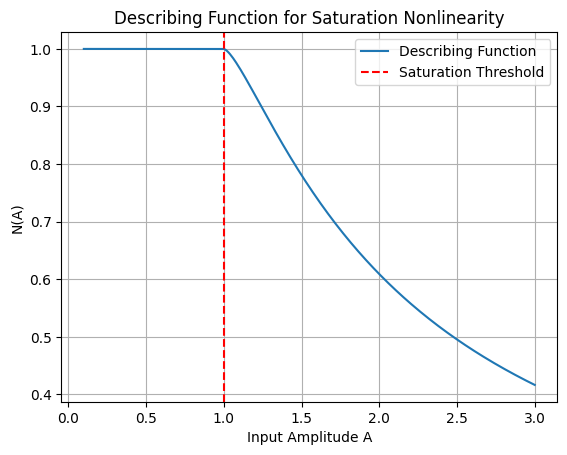

In [9]:
def saturation_describing_function(A, M):
    if A <= M:
        return 1
    else:
        return (2/np.pi) * (np.arcsin(M/A) + (M/A) * np.sqrt(1 - (M/A)**2))

# Example parameters
A_values = np.linspace(0.1, 3, 300)
M = 1.0
N_values = [saturation_describing_function(A, M) for A in A_values]

plt.plot(A_values, N_values, label='Describing Function')
plt.axvline(x=M, color='r', linestyle='--', label='Saturation Threshold')
plt.title('Describing Function for Saturation Nonlinearity')
plt.xlabel('Input Amplitude A')
plt.ylabel('N(A)')
plt.legend()
plt.grid(True)
plt.show()
